Begin by loading the `rstan` package, and data for duration in men and women.

In [1]:
library(rstan)

load("data_m.RData")
load("data_f.RData")

Loading required package: ggplot2
Loading required package: StanHeaders
Warning message:
"package 'StanHeaders' was built under R version 3.2.5"rstan (Version 2.12.1, packaged: 2016-09-11 13:07:50 UTC, GitRev: 85f7a56811da)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


Now run the Stan models to sample from posterior parameter distributions for men and women.

In [2]:
# ####################
# # initial values
# ####################

# # Initial values - 0
# init0 <- list(psi = 7/77, lambda_slow = 0.74, p1 = 0.23)

# # Initial values - 1
# init1 <- list(psi = 0.9, lambda_slow = 0.7, p1 = 0.2)

# # Initial values - 2
# init2 <- list(psi = 0.6, lambda_slow = 0.1, p1 = 0.5)

# ####################
# # run the model
# ####################

# fit_m <- stan(file = 'chlamydia_two_exponentials_men.stan', 
#               data = chlamydia_dat_m, 
#               iter = 22000, warmup = 2000, init=list(init0, init1, init2), chains = 3, seed=12345,
#               sample_file = 'results/sample_men.csv'
#              )

# op_m <- extract(fit_m)

# fit_f <- stan(file = 'chlamydia_two_exponentials_women.stan', 
#               data = chlamydia_dat_f, 
#               iter = 22000, warmup = 2000, init=list(init0, init1, init2), chains = 3, seed=12345,
#               sample_file = 'results/sample_women.csv'
#              )

# op_f <- extract(fit_f)


Alternatively, you can read in the samples from files that have already been run:

In [3]:
fit_m <- read_stan_csv(c('results/sample_men_1.csv', 'results/sample_men_2.csv', 'results/sample_men_3.csv'))
op_m <- extract(fit_m)

fit_f <- read_stan_csv(c('results/sample_women_1.csv', 'results/sample_women_2.csv', 'results/sample_women_3.csv'))
op_f <- extract(fit_f)

Warning message in if (adapt_term_lineno == len) adaptation_info <- "" else {:
"the condition has length > 1 and only the first element will be used"Warning message in (adapt_term_lineno + 1):(time_lineno - 1):
"numerical expression has 2 elements: only the first used"Warning message in 1:(adapt_term_lineno - 1):
"numerical expression has 2 elements: only the first used"Warning message in if (adapt_term_lineno == len) adaptation_info <- "" else {:
"the condition has length > 1 and only the first element will be used"Warning message in (adapt_term_lineno + 1):(time_lineno - 1):
"numerical expression has 2 elements: only the first used"Warning message in 1:(adapt_term_lineno - 1):
"numerical expression has 2 elements: only the first used"Warning message in if (adapt_term_lineno == len) adaptation_info <- "" else {:
"the condition has length > 1 and only the first element will be used"Warning message in (adapt_term_lineno + 1):(time_lineno - 1):
"numerical expression has 2 elements: only 

## Summarise posterior distributions

In [89]:
paste('Posterior mean average duration of infection:', round(mean(1/op_m$lambda_slow),2), 'years.')
paste('Posterior mean slow clearance rate:', round(mean(op_m$lambda_slow),2), 'per year.')
paste('1 / Posterior mean slow clearance rate:', round(1/mean(op_m$lambda_slow),2), 'years.')
paste('50th (2.5th, 97.5th) centiles for slow clearance rate: ', 
      round(quantile(op_m$lambda_slow, p=0.5),2), 
      ' (', round(quantile(op_m$lambda_slow, p=0.025),2), ',', 
      round(quantile(op_m$lambda_slow, p=0.975),2), ') ',
      'per year.', sep='')
log(2)/quantile(op_m$lambda_slow, p=c(0.025, 0.5, 0.975))
paste('Corresponding infection durations: ', 
      round(1/quantile(op_m$lambda_slow, p=0.5),2), 
      ' (', round(1/quantile(op_m$lambda_slow, p=0.975),2), ',', 
      round(1/quantile(op_m$lambda_slow, p=0.025),2), ') ',
      'years.', sep='')

paste('Posterior mean proportion slow-clearing: ', round(1 - mean(op_m$p1),3), '.', sep="")
paste('50th (2.5th, 97.5th) centiles for proportion slow-clearing: ', 
      round(quantile(1 - op_m$p1, p=0.5),3), 
      ' (', 1 - round(quantile(op_m$p1, p=0.975),3), ',', 
      1 - round(quantile(op_m$p1, p=0.025),3), ') ',
      '.', sep='')


[1] "Posterior mean average duration of infection: 4.66 years."

[1] "Posterior mean slow clearance rate: 0.42 per year."

[1] "1 / Posterior mean slow clearance rate: 2.4 years."

[1] "50th (2.5th, 97.5th) centiles for slow clearance rate: 0.35 (0.05,1.15) per year."

2.5%        50%      97.5% 
13.0247654  1.9657783  0.6029935

[1] "Corresponding infection durations: 2.84 (0.87,18.79) years."

[1] "Posterior mean proportion slow-clearing: 0.677."

[1] "50th (2.5th, 97.5th) centiles for proportion slow-clearing: 0.677 (0.573,0.779) ."

In [64]:
# expectation of the deviance
Dbar_m <- mean(op_m$sumdev)

# Effective number of parameters (Spiegelhalter)
thetabar <- apply(op_m$theta,2,mean)
D_thetabar <- -2*sum(
    dbinom(chlamydia_dat_m$r, chlamydia_dat_m$n, thetabar, log=TRUE) -
    dbinom(chlamydia_dat_m$r, chlamydia_dat_m$n, chlamydia_dat_m$r/chlamydia_dat_m$n, log=TRUE)	
    )
p_DS_m <- Dbar_m - D_thetabar

# Effective number of parameters (Gelman)
p_DG_m <- 0.5 * var(op_m$sumdev)

# choose your p_D
p_Dm <- p_DS_m

# DIC
DIC_m <- p_Dm + Dbar_m

paste('Posterior mean residual deviance: ', round(Dbar_m,1), '.', collapse="")
paste('DIC: ', round(DIC_m,1), '.', collapse="")

[1] "Posterior mean residual deviance:  21.6 ."

[1] "DIC:  23.3 ."

## Posterior predictive check

Examine the results by comparing posterior predictions of the number of cleared infections to the observations

In [4]:
# get crude estimates of clearance rate

t <- chlamydia_dat_m$t 
n <- chlamydia_dat_m$n 
r <- chlamydia_dat_m$r 

theta <- matrix(nrow=length(n), ncol=3)  # proportion cleared infection. each row is (estimate, lower, upper)
md <- matrix(nrow=length(n), ncol=3)     # mean duration of infection. each row is (estimate, lower, upper)

for(i in 1:length(n)){
    theta[i,1] <- r[i]/n[i]
    md[i,1] <- -t[i]/log(1 - theta[i,1])

    theta[i,2] <- binom.test(r[i],n[i])[['conf.int']][1]
    md[i,3] <- -t[i]/log(1 - theta[i,2])

    theta[i,3] <- binom.test(r[i],n[i])[['conf.int']][2]
    md[i,2] <- -t[i]/log(1 - theta[i,3])
    }

# also get mean duration corresponding to each data point, using posterior samples

md_sim <- matrix(rep(-t, each=nrow(op_m$r_sim)), nrow=nrow(op_m$r_sim)) / log(1 - op_m$theta)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"6 x values <= 0 omitted from logarithmic plot"

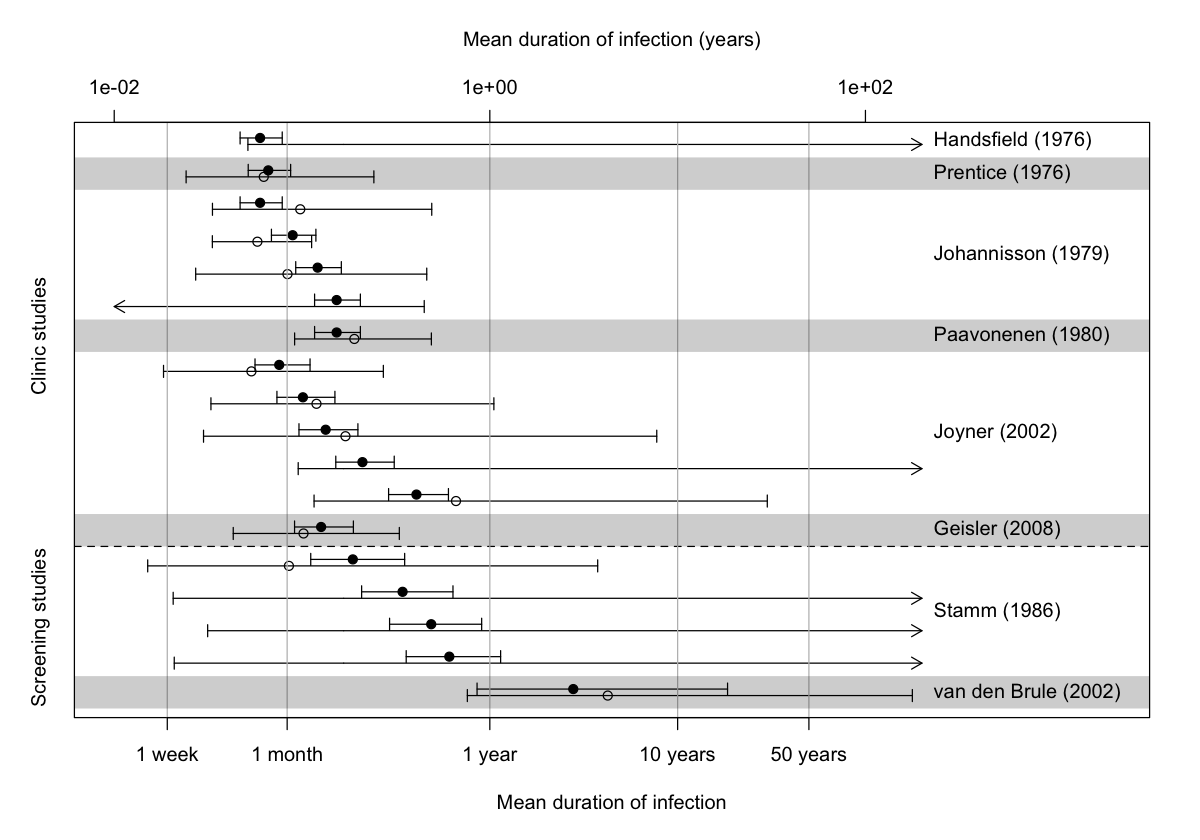

In [5]:
# observed mean duration of infection
options(repr.plot.width=10, repr.plot.height=7)
par(mar = c(5.1, 3.1, 5.1, 2.1))
plot(md[,1], seq(length(n),1,-1), log='x', xlim=c(0.01,2000), xlab = "Mean duration of infection", ylab = "", xaxt="n", yaxt="n")
arrows(y0=seq(length(n),1,-1), x0=md[,2], x1=md[,3], length=0.05, angle=90, code=3)
# special arrows where all recovered
arrows(y0=seq(length(n),1,-1)[n == r], x0=1/52, x1=md[n == r,3], length=0.05, angle=90, code=2) # all recovered
arrows(y0=seq(length(n),1,-1)[n == r], x0=1e-2, x1=1/52, length=0.1, angle=30, code=1) # all recovered
# special arrows where nobody recovered
arrows(y0=seq(length(n),1,-1)[r == 0], x0=2e2, x1=2/12, length=0.1, angle=30, code=1) # none recovered
arrows(y0=seq(length(n),1,-1)[r == 0], x0=2/12, x1=md[r == 0,2], length=0.05, angle=90, code=2) # none recovered

points(apply(md_sim,2,median), seq(length(n),1,-1) + 0.2, pch=19)
arrows(y0=seq(length(n),1,-1) + 0.2, x0=apply(md_sim, 2, quantile, p=0.025), x1=apply(md_sim, 2, quantile, p=0.975), length=0.05, angle=90, code=3)

abline(h=5.6, lty=2)
abline(v = 50, col="grey")
abline(v = 10, col="grey")
abline(v = 1, col="grey")
abline(v = 1/12, col="grey")
abline(v = 7/365.25, col="grey")
axis(side = 1, at = c(7/365.25, 1/12, 1, 10, 50), labels = c("1 week", "1 month", "1 year", "10 years", "50 years"))
axis(side = 2, at = c(3.1, 12.1), labels = c("Screening studies", "Clinic studies"), tick=FALSE)
axis(side = 3)
mtext(side=3, text="Mean duration of infection (years)", line=3)

polygon(c(0.001, 5000, 5000, 0.001), c(0.6, 0.6, 1.6, 1.6), col=rgb(0,0,0,0.2), border=NA)
text(200, 1.1, "van den Brule (2002)", pos=4)
text(200, mean(c(2, 5.2)), "Stamm (1986)", pos=4)
polygon(c(0.001, 5000, 5000, 0.001), c(5.6, 5.6, 6.6, 6.6), col=rgb(0,0,0,0.2), border=NA)
text(200, 6.1, "Geisler (2008)", pos=4)
text(200, mean(c(7, 11.2)), "Joyner (2002)", pos=4)
polygon(c(0.001, 5000, 5000, 0.001), c(11.6, 11.6, 12.6, 12.6), col=rgb(0,0,0,0.2), border=NA)
text(200, 12.1, "Paavonenen (1980)", pos=4)
text(200, mean(c(13, 16.2)), "Johannisson (1979)", pos=4)
polygon(c(0.001, 5000, 5000, 0.001), c(16.6, 16.6, 17.6, 17.6), col=rgb(0,0,0,0.2), border=NA)
text(200, 17.1, "Prentice (1976)", pos=4)
text(200, 18.1, "Handsfield (1976)", pos=4)


## Posterior distribution for the clearance rate of slow infections in men

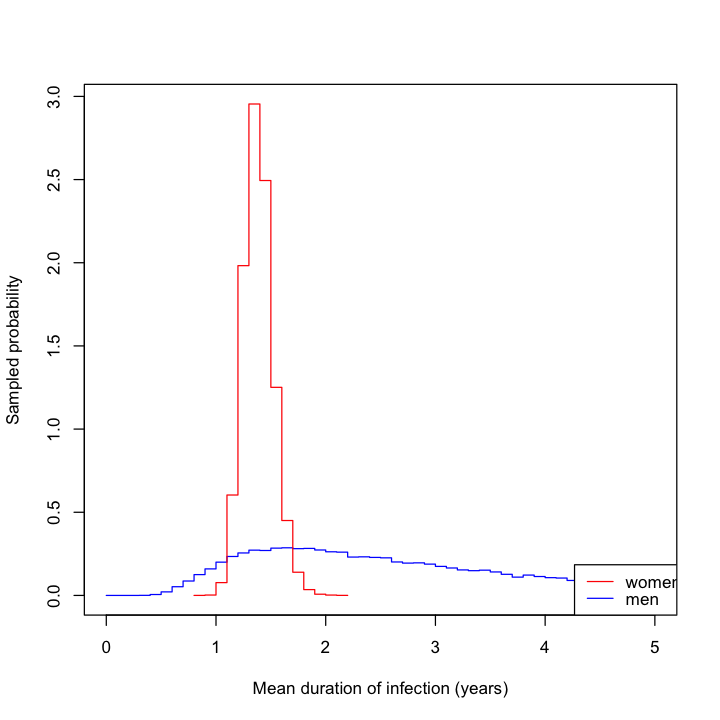

In [21]:
################################
# figure: posterior for duration of infection
################################

fhist <- hist(1/op_f$lambda_slow, plot=FALSE)
fxhist <- c(min(fhist$breaks), fhist$breaks)
fyhist <- c(0, fhist$density, 0)

mhist <- hist(1/op_m$lambda_slow, breaks=seq(0, ceiling(max(1/op_m$lambda_slow)), fxhist[3] - fxhist[2]), plot=FALSE)
mxhist <- c(min(mhist$breaks), mhist$breaks)
myhist <- c(0, mhist$density, 0)

options(repr.plot.width=6, repr.plot.height=6)
par(cex=6/7)
plot(mxhist, myhist, type="s", xlim=c(0,5), ylim=c(0,max(c(myhist, fyhist))),  
     col='blue', # Use this line for colour version. Otherwise, comment-out.
     xlab = "Mean duration of infection (years)",
     ylab = "Sampled probability"
    )
lines(fxhist, fyhist, type="s", ylim=c(0,max(fyhist)), 
      col='red' # this line for colour version. Otherwise, comment-out.
      #col=gray(0.5), lty=2 # this line for black and white
     )

legend('bottomright', lty=1, col=c(2,4), legend=c("women", "men"), bg='white') # colour
#legend('bottomright', lty=c(2,1), col=c(gray(0.5),1), legend=c("women", "men"), bg='white') # black and white
#legend('topright', legend='A', cex=4, bty='n', adj=c(0,0))


In [94]:
##################################
# survival curves
##################################

lambda_fast <- 49

data <- read.csv('~/Documents/ct_natural_history/clearance_rate_men/chlamydia_two_exponentials_070716.csv')

# set up matrices for results
sim_times <- seq(0, 10, 0.1)
sims_slow <- matrix(nrow=nrow(data), ncol=length(sim_times))
sims_all <- matrix(nrow=nrow(data), ncol=length(sim_times))
sims_prev <- matrix(nrow=nrow(data), ncol=length(sim_times))

for(i in 1:nrow(data)){

    sims_slow[i,] <- exp(-data$lambda_slow[i] * sim_times)
    sims_all[i,] <- data$p_fast[i]*exp(-lambda_fast * sim_times) + (1-data$p_fast[i])*exp(-data$lambda_slow[i] * sim_times)
    
    wk <- c(data$p_fast[i]/lambda_fast, (1-data$p_fast[i])/data$lambda_slow[i]) / (data$p_fast[i]/lambda_fast + (1-data$p_fast[i])/data$lambda_slow[i])

    sims_prev[i,] <- wk[1]*exp(-lambda_fast * sim_times) + wk[2]*exp(-data$lambda_slow[i] * sim_times)
    
    }


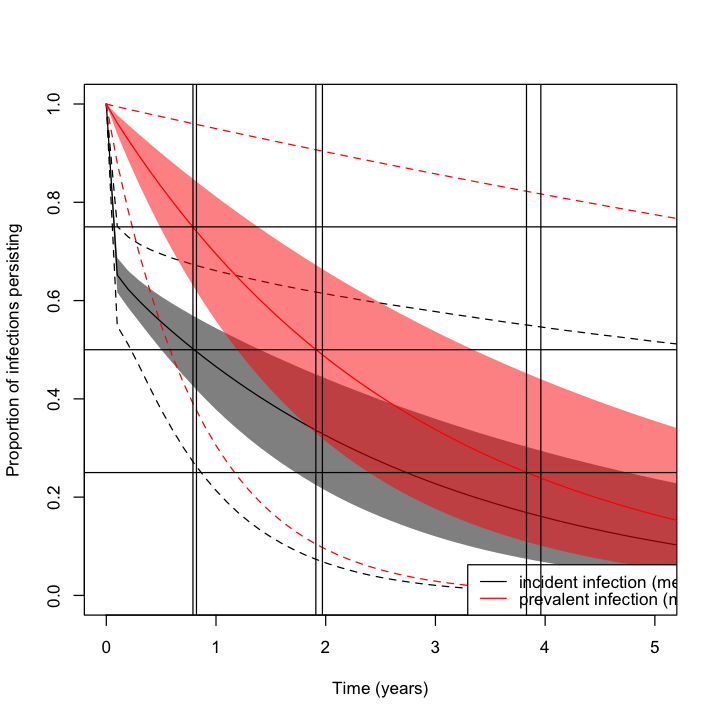

In [101]:
options(repr.plot.width=6, repr.plot.height=6)
par(cex=6/7)
plot(sim_times, apply(sims_all, 2, median), type='l', ylim=c(0,1), xlim=c(0,5), xlab='Time (years)', ylab='Proportion of infections persisting')
polygon(
    c(sim_times, rev(sim_times)), c(apply(sims_all, 2, quantile, p=0.25), rev(apply(sims_all, 2, quantile, p=0.75))), border=NA,
    col=rgb(0,0,0,0.5) # colour
    # density = 20, col = gray(0.8) # black and white
    )
lines(sim_times, apply(sims_all, 2, quantile, p=0.025), lty=2)
lines(sim_times, apply(sims_all, 2, quantile, p=0.975), lty=2)

lines(sim_times, apply(sims_prev, 2, quantile, p=0.5)
      , col=2 # colour
     )
polygon(c(sim_times, rev(sim_times)), c(apply(sims_prev, 2, quantile, p=0.25), rev(apply(sims_prev, 2, quantile, p=0.75))), border=NA,
        col=rgb(1,0,0,0.5) # colour
#        density = 20, col = gray(0.8), angle = 45+90 # black and white
       )
lines(sim_times, apply(sims_prev, 2, quantile, p=0.025), lty=2
      , col=2 # colour
     )
lines(sim_times, apply(sims_prev, 2, quantile, p=0.975), lty=2
      , col=2 # colour
     )

legend('bottomright', lty=1, col=1:2, legend=c("incident infection (men)", "prevalent infection (men)"), bg='white') # colour
#legend('bottomright', density = 20, col = gray(0.8), angle=c(0,90)+45, legend=c("incident infection (men)", "prevalent infection (men)"), bg='white') # black and white
#legend('topright', legend='B', cex=4, bty='n', adj=c(0,0))

abline(h=0.5)
abline(h=0.75)
abline(h=0.25)

abline(v=1.91)
abline(v=1.97)
abline(v=0.79)
abline(v=log(1/0.75)/0.35)
abline(v=3.83)
abline(v=log(1/0.25)/0.35)


In [100]:
# prevalent infections

tol <- 0.0001 # stopping condition
quant <- 0.25 # which quantile are you looking for?
step <- 1.5 # initial step size
bracket <- c(0,step) # initial bracket: lower bound 0 (know below crossover); upper bound step
above <- c(FALSE, NA) # is median above or below threshold at each end of bracket?

wk <- matrix(
    c(data$p_fast/lambda_fast, (1-data$p_fast)/data$lambda_slow) / (data$p_fast/lambda_fast + (1-data$p_fast)/data$lambda_slow),
    ncol=2
    )

above[2] <- sum(
    (wk[,1]*exp(-lambda_fast * bracket[2]) + wk[,2]*exp(-data$lambda_slow * bracket[2]) ) > quant
        ) < 0.5*dim(data)[1]


iter <- 1 # iteration counter
while( ((bracket[2] - bracket[1]) > tol) | (sum(above) != 1) ){

#    print(bracket)
#    print(above)
#    print(step)


    if(sum(above) == 0) { # both below
 #       print('cond1')
        bracket[2] <- max(bracket[2] + step, 0)
        above[2] <- sum(
            (wk[,1]*exp(-lambda_fast * bracket[2]) + wk[,2]*exp(-data$lambda_slow * bracket[2]) ) > quant
        ) < 0.5*dim(data)[1]

    }

    else{ if(sum(above) == 2)	{ # both above
#        print('cond2')
        bracket[1] <- max(bracket[1] - step, 0)
        above[1] <- sum(
            (wk[,1]*exp(-lambda_fast * bracket[1]) + wk[,2]*exp(-data$lambda_slow * bracket[1]) ) > quant
        ) < 0.5*dim(data)[1]

    }

    else { # one each side
#        print('cond3')
        step <- step/2
        bracket <- mean(bracket)*c(1,1)
        above[1] <- sum(
            (wk[,1]*exp(-lambda_fast * bracket[1]) + wk[,2]*exp(-data$lambda_slow * bracket[1]) ) > quant
                ) < 0.5*dim(data)[1]
        above[2] <- sum(
            (wk[,1]*exp(-lambda_fast * bracket[2]) + wk[,2]*exp(-data$lambda_slow * bracket[2]) ) > quant
                ) < 0.5*dim(data)[1]
        
    }}

    iter <- iter + 1
#    print((bracket[2] - bracket[1]) > tol) 
#    print(sum(above) != 1)
    
    if(iter > 1000){
        
#        print(paste('Not coverged; iteration number', iter))
#        print(bracket)
#        print(above)
        break
    }
}

print(bracket)
print(above)
print(iter)

[1] 3.833313 3.833405
[1] FALSE  TRUE
[1] 34


## Differences between men and women

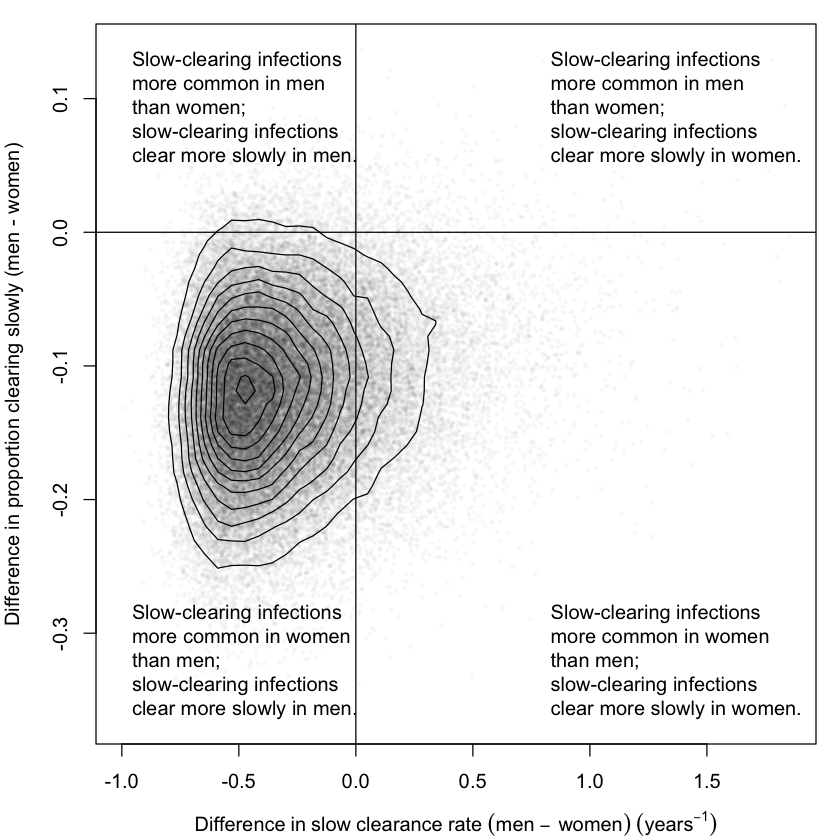

In [18]:
##################################
# differences between men and women
##################################
options(repr.plot.width=7, repr.plot.height=7)
par(mar = c(4,4,1,1))

plot(op_m$lambda_slow - op_f$lambda_slow,
     op_f$p1 - op_m$p1,
     pch=16, cex=0.5, col=rgb(0,0,0,0.03),
     xlab = expression(Difference ~ "in" ~ slow ~ clearance ~ rate ~ (men ~ - ~ women) ~ (years^{-1})),
     ylab = "Difference in proportion clearing slowly (men - women)",
    )
abline(h=0)
abline(v=0)

## some pretty colors
library(MASS)
k <- 11
z <- kde2d(op_m$lambda_slow - op_f$lambda_slow, op_f$p1 - op_m$p1, n=50)
contour(z, drawlabels=FALSE, nlevels=k, col='black', add=TRUE)

legend('topleft', 
       legend = "Slow-clearing infections \nmore common in men \nthan women; \nslow-clearing infections \nclear more slowly in men. ",
       bty='n', adj=c(0,0.25))
legend('bottomleft', 
       legend = "Slow-clearing infections \nmore common in women \nthan men; \nslow-clearing infections \nclear more slowly in men. ",
       bty='n', adj=c(0,-0.05))
legend('topright', 
       legend = "Slow-clearing infections \nmore common in men \nthan women; \nslow-clearing infections \nclear more slowly in women. ",
       bty='n', adj=c(0,0.25))
legend('bottomright', 
       legend = "Slow-clearing infections \nmore common in women \nthan men; \nslow-clearing infections \nclear more slowly in women. ",
       bty='n', adj=c(0,-0.05))


In [79]:
# proportion of samples in halves/quadrants of the plot

paste('Slow-clearing infections clear faster in women: ',
    100*round(
    sum(op_m$lambda_slow < op_f$lambda_slow)/
    length(op_m$lambda_slow),
    2), '%')

paste('Slow-clearing infections more common in women: ',
    100*round(
    sum(op_f$p1 < op_m$p1)/
    length(op_m$lambda_slow),
    2), '%')


paste('Slow-clearing infections more common in women; slow-clearing infections clear more slowly in men: ',
    100*round(
    sum((op_m$lambda_slow < op_f$lambda_slow) & (op_f$p1 < op_m$p1))/
    length(op_m$lambda_slow),
    2), '%')

[1] "Slow-clearing infections clear faster in women:  86 %"

[1] "Slow-clearing infections more common in women:  98 %"

[1] "Slow-clearing infections more common in women; slow-clearing infections clear more slowly in men:  84 %"